<a href="https://colab.research.google.com/github/thunderhoser/ai2es_xai_course/blob/main/lecture04_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 4: More explanation methods for neural networks

This notebook was used for the AI2ES (NSF Institute for Research on Trustworthy Artificial Intelligence in Weather, Climate, and Coastal Oceanography) short course on XAI (explainable artificial intelligence) in May-June 2021.

If you use code from this notebook, please cite it as follows.

Lagerquist, Ryan, and David John Gagne II, 2021: "Lecture 4: More explanation methods for neural networks". AI2ES (NSF Institute for Research on Trustworthy Artificial Intelligence in Weather, Climate, and Coastal Oceanography) short course on XAI (explainable artificial intelligence), https://github.com/thunderhoser/ai2es_xai_course/.

# References

This notebook refers to a few publications, listed below.  Schwartz *et al.* (2015) documents the dataset used.

Erhan, D., Y. Bengio, A. Courville, and P. Vincent, 2009: "Visualizing higher-layer features of a deep network." Tech. rep., https://www.researchgate.net/profile/Aaron-Courville/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network/links/53ff82b00cf24c81027da530/Visualizing-Higher-Layer-Features-of-a-Deep-Network.pdf.

Mamalakis, A., I. Ebert-Uphoff, and E.A. Barnes, 2021: "Neural network attribution methods for problems in geoscience: A novel synthetic benchmark dataset." *arXiv e-prints*, **2103 (10005)**, https://arxiv.org/abs/2103.10005.

McGovern, A., R. Lagerquist, D. Gagne, G. Jergensen, K. Elmore, C. Homeyer, and T. Smith, 2019: "Making the black box more transparent: Understanding the physical implications of machine learning." *Bulletin of the American Meteorological Society*, **100 (11)**, 2175-2199, https://doi.org/10.1175/BAMS-D-18-0195.1.

Montavon, G., W. Samek, and K. Müller, 2018: "Methods for interpreting and understanding deep neural networks." *Digital Signal Processing*, **73**, 1–15, https://doi.org/10.1016/j.dsp.2017.10.011.

Samek, W., T. Wiegand, and K. Müller, 2017: "Explainable artificial intelligence: Understanding, visualizing and interpreting deep learning models." *arXiv e-prints*, **1708 (08296)**, https://arxiv.org/abs/1708.08296.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181, https://doi.org/10.1175/WAF-D-15-0013.1.

Wagstaff, K., and J. Lee: "Interpretable discovery in large image data sets." *arXiv e-prints*, **1806**, https://arxiv.org/abs/1806.08340.


# <font color='red'>Clone the Git repository (required)</font>

- **Please note**: when a section title is in <font color='red'>red</font>, that means the code cell below is required.
- In other words, if you don't run the code cell below, subsequent code cells might not work.

In [ ]:
import os
import shutil

# !pip install 'keras>=2.4.0,<2.5.0' --force-reinstall

if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')

!git clone https://github.com/thunderhoser/ai2es_xai_course course_repository
!cd course_repository; python setup.py install

Cloning into 'course_repository'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 208 (delta 130), reused 136 (delta 62), pack-reused 0
Receiving objects: 100% (208/208), 62.95 MiB | 35.09 MiB/s, done.
Resolving deltas: 100% (130/130), done.
running install
running bdist_egg
running egg_info
creating ai2es_xai_course.egg-info
writing ai2es_xai_course.egg-info/PKG-INFO
writing dependency_links to ai2es_xai_course.egg-info/dependency_links.txt
writing requirements to ai2es_xai_course.egg-info/requires.txt
writing top-level names to ai2es_xai_course.egg-info/top_level.txt
writing manifest file 'ai2es_xai_course.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'ai2es_xai_course.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/ai2es_xai_course


# <font color='red'>Import packages (required)</font>

The next two cells import all packages used in the notebook.

In [ ]:
import sys

sys.path.append('/content/data/')
sys.path.append('/content/course_repository/')
sys.path.append('/content/course_repository/ai2es_xai_course/')
sys.path.append('/content/course_repository/ai2es_xai_course/utils/')

In [ ]:
%matplotlib inline
import copy
import random
import os.path
import warnings
import numpy
import keras
import tensorflow
from matplotlib import pyplot
from ai2es_xai_course.plotting import image_plotting, feature_map_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding, cnn, saliency, occlusion
from ai2es_xai_course.utils import backwards_optimization as backwards_opt

warnings.filterwarnings('ignore')
tensorflow.compat.v1.disable_eager_execution()
tensorflow.compat.v1.experimental.output_all_intermediates(True)

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

TABULAR_DATA_DIR_NAME = '/content/data/track_data_ncar_ams_3km_csv_small'
IMAGE_DATA_DIR_NAME = '/content/data/track_data_ncar_ams_3km_nc_small'

BEST_HIT_MATRIX_KEY = 'best_hits_predictor_matrix'
WORST_FALSE_ALARM_MATRIX_KEY = 'worst_false_alarms_predictor_matrix'
WORST_MISS_MATRIX_KEY = 'worst_misses_predictor_matrix'
BEST_CORRECT_NULLS_MATRIX_KEY = 'best_correct_nulls_predictor_matrix'
PREDICTOR_NAMES_KEY = 'predictor_names'

# <font color='red'>Prevent auto-scrolling (required)</font>

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# <font color='red'>Download input data (required)</font>

The next cell downloads all input data used in this notebook.

In [ ]:
!python /content/course_repository/download_image_data.py

Unzipping file: "data/track_data_ncar_ams_3km_nc_small.tar.gz"...


# <font color='red'>Read input data (required)</font>

The next cell reads all input data for this notebook into memory.

In [ ]:
image_training_file_names = image_utils.find_many_files(
    first_date_string='20100101', last_date_string='20141224',
    directory_name=IMAGE_DATA_DIR_NAME
)

image_validation_file_names = image_utils.find_many_files(
    first_date_string='20150101', last_date_string='20151231',
    directory_name=IMAGE_DATA_DIR_NAME
)

image_testing_file_names = image_utils.find_many_files(
    first_date_string='20160101', last_date_string='20171231',
    directory_name=IMAGE_DATA_DIR_NAME
)

training_image_dict = image_utils.read_many_files(image_training_file_names)
print('\n')

validation_image_dict = image_utils.read_many_files(image_validation_file_names)
print('\n')

testing_image_dict = image_utils.read_many_files(image_testing_file_names)

Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110414-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARS

# <font color='red'>Normalization (required)</font>

The next cell does the following:

 - Finds normalization parameters (mean and standard deviation) for each channel, based only on the training data.
 - But does not actually normalize any data (this will be done on the fly, as needed).  Keeping a normalized and unnormalized version of each dataset (training, validation, and testing) would take up too much memory.

In [ ]:
image_normalization_dict = image_normalization.get_normalization_params(
    image_dict=training_image_dict
)

# <font color='red'>Binarization of target variable (required)</font>

The next cell does the following:

 - Finds the binarization threshold (on max future vorticity in s$^{-1}$) for image data.
 - Does not actually binarize image data (this will be done on the fly, as needed).

In [ ]:
image_binarization_threshold = image_thresholding.get_binarization_threshold(
    image_dict=training_image_dict, percentile_level=90.
)


Binarization threshold for "max_future_vorticity_s01" = 5.4310e-03


# <font color='red'>Read pre-trained CNN (required)</font>

The next cell reads a pre-trained CNN, which will be used for all explanation methods in this notebook.

In [ ]:
cnn_file_name = '/content/course_repository/pretrained_cnn/model.h5'
cnn_model_object = utils.read_dense_net(cnn_file_name)
cnn_model_object.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1184      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
________________________________________________

# Extreme cases for pre-trained CNN

There are four types of extreme cases, defined below.  A positive (negative) example is a storm that does (not) develop strong rotation in the future.

 - **Best hits**: the 100 positive examples with highest forecast probability
 - **Worst false alarms**: the 100 negative examples with highest forecast probability
 - **Worst misses**: the 100 positive examples with lowest forecast probability
 - **Best correct nulls**: the 100 negative examples with lowest forecast probability

## <font color='red'>Find extreme cases (required)</font>

The next cell finds extreme cases for the pre-trained CNN.

In [ ]:
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

testing_predictor_matrix_denorm = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
)

testing_predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(testing_predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

testing_classes = image_thresholding.binarize_target_images(
    target_matrix=testing_image_dict[image_utils.TARGET_MATRIX_KEY],
    binarization_threshold=image_binarization_threshold
)

testing_probs = cnn.apply_model(
    model_object=cnn_model_object,
    predictor_matrix=testing_predictor_matrix_norm
)

this_dict = utils.find_extreme_examples(
    observed_labels=testing_classes, forecast_probabilities=testing_probs,
    num_examples_per_set=100
)
best_hit_indices = this_dict[utils.HIT_INDICES_KEY]
worst_false_alarm_indices = this_dict[utils.FALSE_ALARM_INDICES_KEY]
worst_miss_indices = this_dict[utils.MISS_INDICES_KEY]
best_correct_null_indices = this_dict[utils.CORRECT_NULL_INDICES_KEY]

extreme_example_dict_denorm = {
    BEST_HIT_MATRIX_KEY:
        testing_predictor_matrix_denorm[best_hit_indices, ...],
    WORST_FALSE_ALARM_MATRIX_KEY:
        testing_predictor_matrix_denorm[worst_false_alarm_indices, ...],
    WORST_MISS_MATRIX_KEY:
        testing_predictor_matrix_denorm[worst_miss_indices, ...],
    BEST_CORRECT_NULLS_MATRIX_KEY:
        testing_predictor_matrix_denorm[best_correct_null_indices, ...],
    PREDICTOR_NAMES_KEY: predictor_names
}

extreme_example_dict_norm = {
    BEST_HIT_MATRIX_KEY:
        testing_predictor_matrix_norm[best_hit_indices, ...],
    WORST_FALSE_ALARM_MATRIX_KEY:
        testing_predictor_matrix_norm[worst_false_alarm_indices, ...],
    WORST_MISS_MATRIX_KEY:
        testing_predictor_matrix_norm[worst_miss_indices, ...],
    BEST_CORRECT_NULLS_MATRIX_KEY:
        testing_predictor_matrix_norm[best_correct_null_indices, ...],
    PREDICTOR_NAMES_KEY: predictor_names
}

this_bh_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[BEST_HIT_MATRIX_KEY]
)
this_wfa_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[WORST_FALSE_ALARM_MATRIX_KEY]
)
this_wm_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[WORST_MISS_MATRIX_KEY]
)
this_bcn_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[BEST_CORRECT_NULLS_MATRIX_KEY]
)

extreme_example_dict_denorm_pmm = {
    BEST_HIT_MATRIX_KEY: this_bh_matrix,
    WORST_FALSE_ALARM_MATRIX_KEY: this_wfa_matrix,
    WORST_MISS_MATRIX_KEY: this_wm_matrix,
    BEST_CORRECT_NULLS_MATRIX_KEY: this_bcn_matrix,
    PREDICTOR_NAMES_KEY: predictor_names
}

Applying model to examples 0-999 of 19368...
Applying model to examples 1000-1999 of 19368...
Applying model to examples 2000-2999 of 19368...
Applying model to examples 3000-3999 of 19368...
Applying model to examples 4000-4999 of 19368...
Applying model to examples 5000-5999 of 19368...
Applying model to examples 6000-6999 of 19368...
Applying model to examples 7000-7999 of 19368...
Applying model to examples 8000-8999 of 19368...
Applying model to examples 9000-9999 of 19368...
Applying model to examples 10000-10999 of 19368...
Applying model to examples 11000-11999 of 19368...
Applying model to examples 12000-12999 of 19368...
Applying model to examples 13000-13999 of 19368...
Applying model to examples 14000-14999 of 19368...
Applying model to examples 15000-15999 of 19368...
Applying model to examples 16000-16999 of 19368...
Applying model to examples 17000-17999 of 19368...
Applying model to examples 18000-18999 of 19368...
Applying model to examples 19000-19367 of 19368...
Have

## Plot extreme cases

 - The next cell plots a composite (average storm) for each set of extreme cases.
 - Specifically, we plot the PMM (probability-matched means; Ebert 2001) composite.
 - PMM is similar to taking the arithmetic mean at each grid cell, but it preserves spatial structure better.

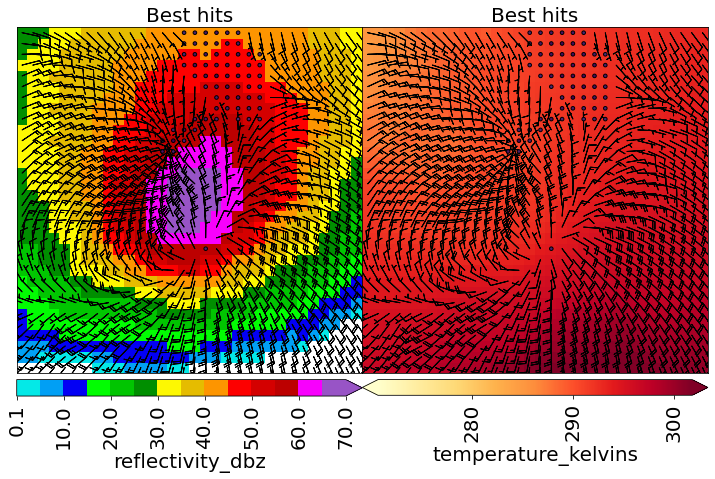

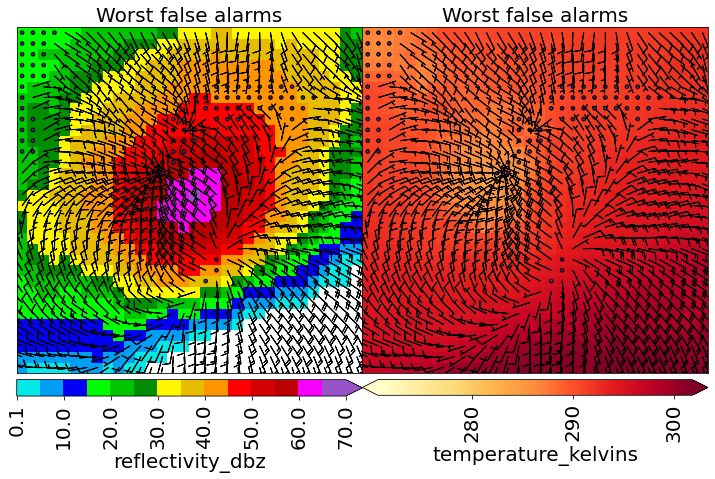

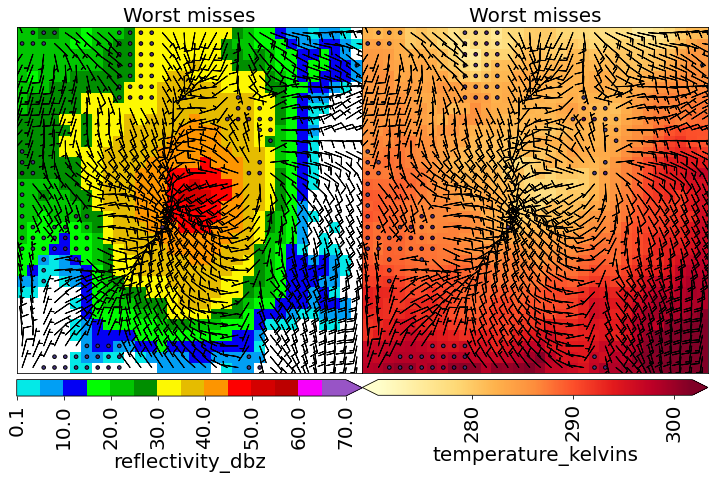

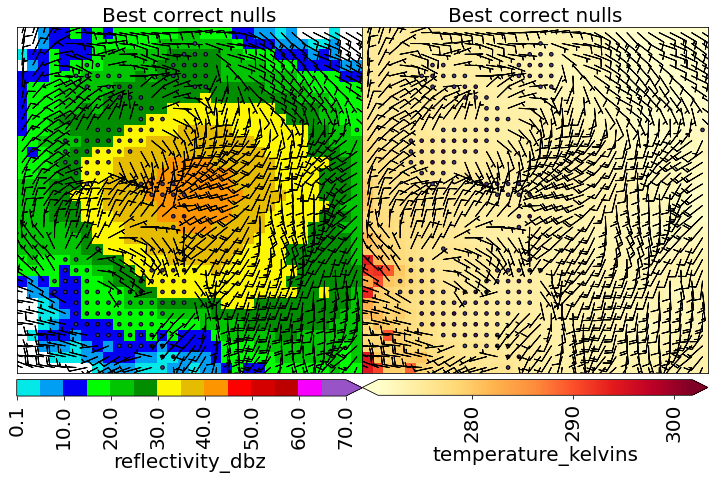

In [ ]:
best_hits_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    BEST_HIT_MATRIX_KEY
]
worst_fa_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    WORST_FALSE_ALARM_MATRIX_KEY
]
worst_misses_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    WORST_MISS_MATRIX_KEY
]
best_nulls_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    BEST_CORRECT_NULLS_MATRIX_KEY
]
predictor_names = extreme_example_dict_denorm_pmm[PREDICTOR_NAMES_KEY]

concat_predictor_matrix = numpy.stack((
    best_hits_matrix_denorm_pmm, worst_fa_matrix_denorm_pmm,
    worst_misses_matrix_denorm_pmm, best_nulls_matrix_denorm_pmm,
), axis=0)

temperature_matrix_kelvins = concat_predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_with_barbs(
        predictor_matrix=best_hits_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins)
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Best hits')

pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_with_barbs(
        predictor_matrix=worst_fa_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins)
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Worst false alarms')

pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_with_barbs(
        predictor_matrix=worst_misses_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins)
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Worst misses')

pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_with_barbs(
        predictor_matrix=best_nulls_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins)
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Best correct nulls')

# Input times gradient

## Theory

 - **Input times gradient = predictor times saliency.**
 - For a climate problem with FCNNs, Mamalakis *et al.* (2021) found that **input-times-gradient maps are closer to ground truth than saliency maps.**
 - Mamalakis *et al.* (2021) compared many other XAI methods and found that the best are as follows:
   - Input times gradient
   - Integrated gradients
   - Layerwise relevance propagation (LRP) with a certain propagation rule
<br><br>
 - **Antonios Mamalakis will give an AI2ES lecture on this paper on Monday Jun 28 2021 from 1230-1400 MDT.**
   - See AI2ES mailing list for details.
<br><br>
 - If the input is predictor $x$, you can think of input * gradient as the contribution of $x$ to the network’s actual output.
 - As opposed to saliency, which is the sensitivity of the network's output to $x$ ("how can $x$ be changed to change the network's output?").

## Input * grad for random example

The next cell computes and plots the input * grad map for a random example in the testing data.  To interpret the plot:

 - Solid contours mean positive contribution from predictor (causing probability of strong rotation, $p$, to increase).
 - Dashed contours mean negative contribution from predictor (causing $p$ to decrease).
 - Positive $u$-wind is westerly (towards the east/right).
 - Positive $v$-wind is southerly (towards the north/top).

Have computed saliency maps for 0 of 1 examples...
Have computed saliency maps for all 1 examples!


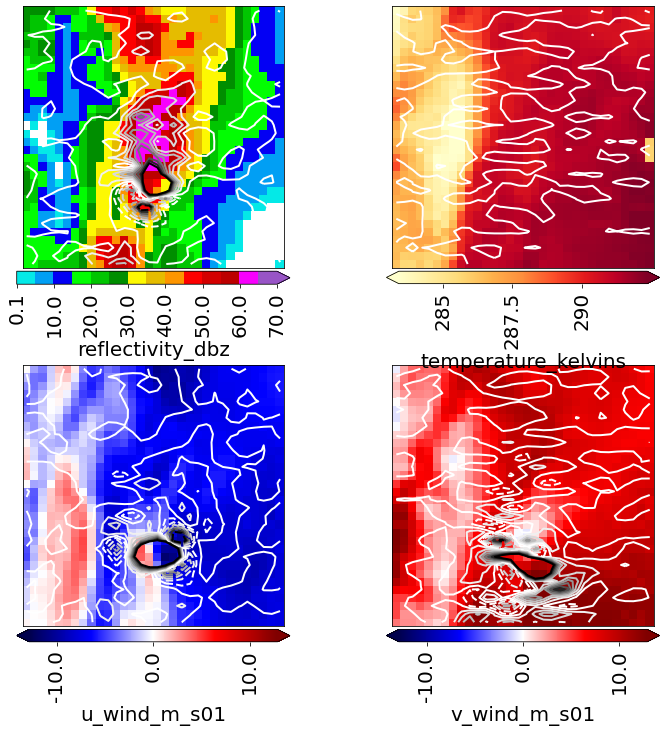

In [ ]:
predictor_matrix_denorm = testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

num_examples = predictor_matrix_denorm.shape[0]
random_index = random.randint(0, num_examples - 1)
# random_index = 14138
predictor_matrix_denorm = predictor_matrix_denorm[random_index, ...]

predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

saliency_matrix = utils.get_saliency_one_neuron(
    model_object=cnn_model_object,
    predictor_matrix=numpy.expand_dims(predictor_matrix_norm, axis=0),
    layer_name=cnn_model_object.layers[-1].name,
    neuron_indices=numpy.array([0], dtype=int),
    ideal_activation=1.
)[0, ...]

input_times_grad_matrix = predictor_matrix_norm * saliency_matrix
input_times_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[input_times_grad_matrix], smoothing_radius_grid_cells=1
)[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(image_utils.U_WIND_NAME),
    predictor_names.index(image_utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_colour_value = numpy.percentile(numpy.absolute(input_times_grad_matrix), 99)

saliency.plot_saliency_maps(
    saliency_matrix_3d=input_times_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_colour_value,
    contour_interval=max_colour_value / 8
)

## Input * grad for strong example

The next cell computes and plots the input * grad map for the strongest example in the testing data (that with the greatest max future vorticity).

Have computed saliency maps for 0 of 1 examples...
Have computed saliency maps for all 1 examples!


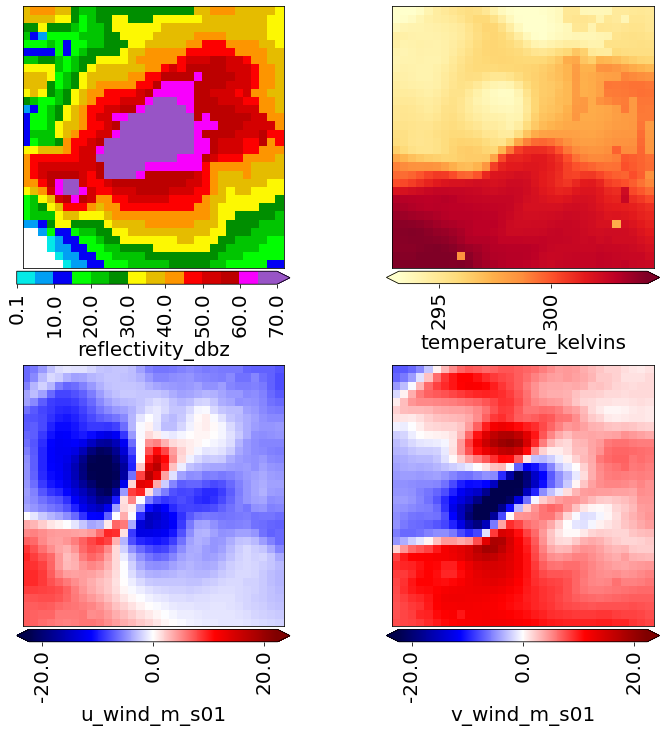

In [ ]:
target_matrix_s01 = testing_image_dict[image_utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix_denorm = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY][example_index, ...]
)
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

saliency_matrix = utils.get_saliency_one_neuron(
    model_object=cnn_model_object,
    predictor_matrix=numpy.expand_dims(predictor_matrix_norm, axis=0),
    layer_name=cnn_model_object.layers[-1].name,
    neuron_indices=numpy.array([0], dtype=int),
    ideal_activation=1.
)[0, ...]

input_times_grad_matrix = predictor_matrix_norm * saliency_matrix
input_times_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[input_times_grad_matrix], smoothing_radius_grid_cells=1
)[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(image_utils.U_WIND_NAME),
    predictor_names.index(image_utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_colour_value = numpy.percentile(numpy.absolute(input_times_grad_matrix), 99)

saliency.plot_saliency_maps(
    saliency_matrix_3d=input_times_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_colour_value,
    contour_interval=max_colour_value / 8
)

## Input * grad for extreme cases

The next two cells compute, then plot, the composite (PMM) input * grad map for each set of extreme cases.

In [ ]:
best_hits_saliency_matrix = utils.get_saliency_one_neuron(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[BEST_HIT_MATRIX_KEY],
    layer_name=cnn_model_object.layers[-1].name,
    neuron_indices=numpy.array([0], dtype=int),
    ideal_activation=1.
)
best_hits_input_times_grad_matrix = (
    best_hits_saliency_matrix *
    extreme_example_dict_norm[BEST_HIT_MATRIX_KEY]
)
best_hits_input_times_grad_matrix = utils.run_pmm_many_variables(
    field_matrix=best_hits_input_times_grad_matrix
)
best_hits_input_times_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[best_hits_input_times_grad_matrix],
    smoothing_radius_grid_cells=1
)[0]

worst_false_alarms_saliency_matrix = utils.get_saliency_one_neuron(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[WORST_FALSE_ALARM_MATRIX_KEY],
    layer_name=cnn_model_object.layers[-1].name,
    neuron_indices=numpy.array([0], dtype=int),
    ideal_activation=1.
)
wfa_input_times_grad_matrix = (
    worst_false_alarms_saliency_matrix *
    extreme_example_dict_norm[WORST_FALSE_ALARM_MATRIX_KEY]
)
wfa_input_times_grad_matrix = utils.run_pmm_many_variables(
    field_matrix=wfa_input_times_grad_matrix
)
wfa_input_times_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[wfa_input_times_grad_matrix],
    smoothing_radius_grid_cells=1
)[0]

worst_misses_saliency_matrix = utils.get_saliency_one_neuron(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[WORST_MISS_MATRIX_KEY],
    layer_name=cnn_model_object.layers[-1].name,
    neuron_indices=numpy.array([0], dtype=int),
    ideal_activation=1.
)
worst_misses_input_times_grad_matrix = (
    worst_misses_saliency_matrix *
    extreme_example_dict_norm[WORST_MISS_MATRIX_KEY]
)
worst_misses_input_times_grad_matrix = utils.run_pmm_many_variables(
    field_matrix=worst_misses_input_times_grad_matrix
)
worst_misses_input_times_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[worst_misses_input_times_grad_matrix],
    smoothing_radius_grid_cells=1
)[0]

best_correct_nulls_saliency_matrix = utils.get_saliency_one_neuron(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[BEST_CORRECT_NULLS_MATRIX_KEY],
    layer_name=cnn_model_object.layers[-1].name,
    neuron_indices=numpy.array([0], dtype=int),
    ideal_activation=1.
)
bcn_input_times_grad_matrix = (
    best_correct_nulls_saliency_matrix *
    extreme_example_dict_norm[BEST_CORRECT_NULLS_MATRIX_KEY]
)
bcn_input_times_grad_matrix = utils.run_pmm_many_variables(
    field_matrix=bcn_input_times_grad_matrix
)
bcn_input_times_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[bcn_input_times_grad_matrix],
    smoothing_radius_grid_cells=1
)[0]

Have computed saliency maps for 0 of 100 examples...
Have computed saliency maps for all 100 examples!
Have computed saliency maps for 0 of 100 examples...
Have computed saliency maps for all 100 examples!
Have computed saliency maps for 0 of 100 examples...
Have computed saliency maps for all 100 examples!
Have computed saliency maps for 0 of 100 examples...
Have computed saliency maps for all 100 examples!


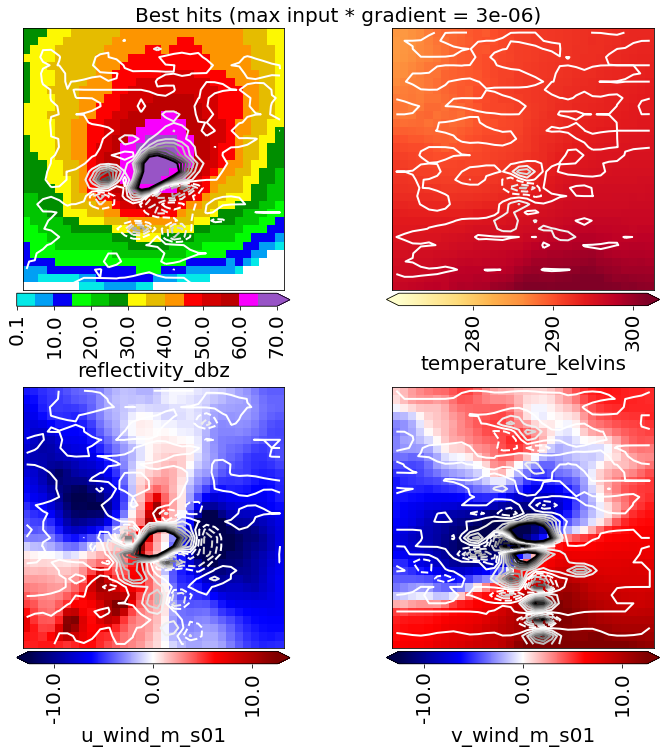

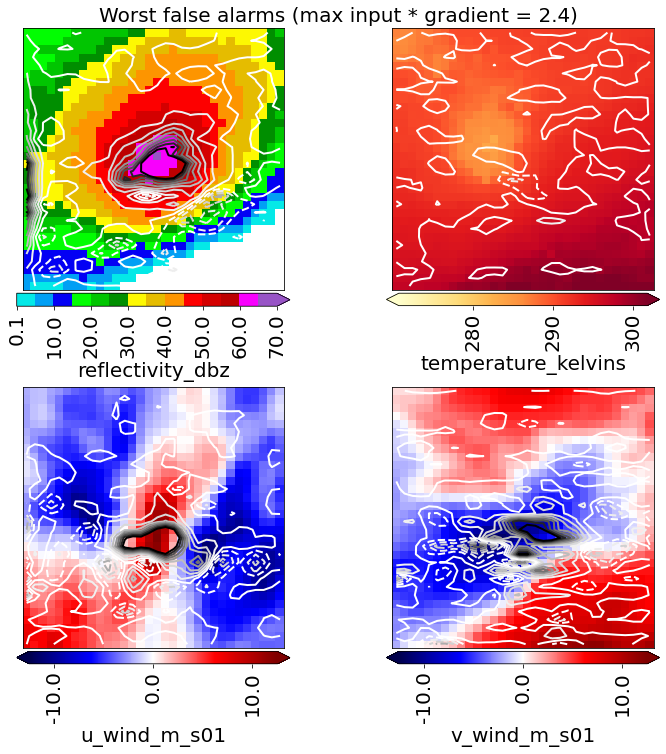

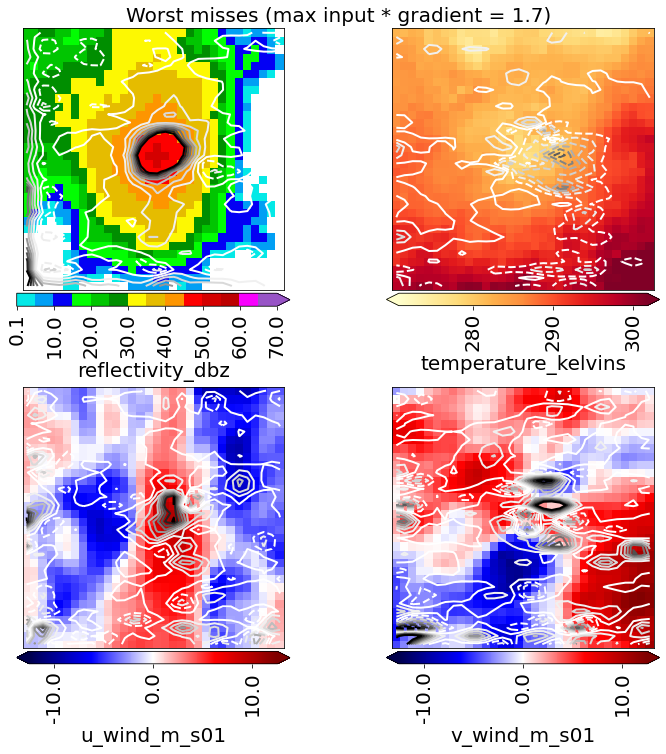

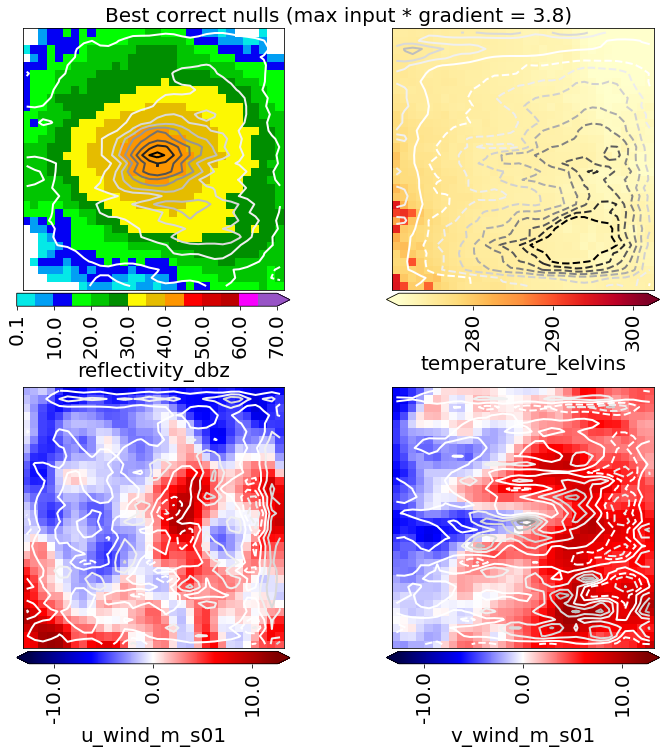

In [ ]:
predictor_names = extreme_example_dict_denorm_pmm[PREDICTOR_NAMES_KEY]

concat_predictor_matrix = numpy.stack((
    extreme_example_dict_denorm_pmm[BEST_HIT_MATRIX_KEY],
    extreme_example_dict_denorm_pmm[WORST_FALSE_ALARM_MATRIX_KEY],
    extreme_example_dict_denorm_pmm[WORST_MISS_MATRIX_KEY],
    extreme_example_dict_denorm_pmm[BEST_CORRECT_NULLS_MATRIX_KEY]
), axis=0)

temperature_matrix_kelvins = concat_predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(image_utils.U_WIND_NAME),
    predictor_names.index(image_utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(concat_predictor_matrix[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=extreme_example_dict_denorm_pmm[BEST_HIT_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_input_times_grad = numpy.percentile(
    numpy.absolute(best_hits_input_times_grad_matrix), 99
)
saliency.plot_saliency_maps(
    saliency_matrix_3d=best_hits_input_times_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_input_times_grad,
    contour_interval=max_input_times_grad / 8
)

figure_object.suptitle(
    'Best hits (max input * gradient = {0:.2g})'.format(
        max_input_times_grad
    )
)
pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=
        extreme_example_dict_denorm_pmm[WORST_FALSE_ALARM_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_input_times_grad = numpy.percentile(
    numpy.absolute(wfa_input_times_grad_matrix), 99
)
saliency.plot_saliency_maps(
    saliency_matrix_3d=wfa_input_times_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_input_times_grad,
    contour_interval=max_input_times_grad / 8
)

figure_object.suptitle(
    'Worst false alarms (max input * gradient = {0:.2g})'.format(
        max_input_times_grad
    )
)
pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=
        extreme_example_dict_denorm_pmm[WORST_MISS_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_input_times_grad = numpy.percentile(
    numpy.absolute(worst_misses_input_times_grad_matrix), 99
)
saliency.plot_saliency_maps(
    saliency_matrix_3d=worst_misses_input_times_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_input_times_grad,
    contour_interval=max_input_times_grad / 8
)

figure_object.suptitle(
    'Worst misses (max input * gradient = {0:.2g})'.format(
        max_input_times_grad
    )
)
pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=
        extreme_example_dict_denorm_pmm[BEST_CORRECT_NULLS_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_input_times_grad = numpy.percentile(
    numpy.absolute(bcn_input_times_grad_matrix), 99
)
saliency.plot_saliency_maps(
    saliency_matrix_3d=bcn_input_times_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_input_times_grad,
    contour_interval=max_input_times_grad / 8
)

figure_object.suptitle(
    'Best correct nulls (max input * gradient = {0:.2g})'.format(
        max_input_times_grad
    )
)
pyplot.show()

# Occlusion maps

## Theory

 - **Occlusion maps are created for one class and one image (data example) at a time.**
 - **An occlusion map for class $k$ is created as follows:**
   1. Choose the size of the occlusion window (e.g., 3 x 3).
   2. Choose the fill value, $x_{\textrm{fill}}$.  At each position of the occlusion window, all predictors will be replaced by $x_{\textrm{fill}}$.
   3. For each pixel $(i, j)$ in the image:<br>
      a) Center the occlusion window at pixel $(i, j)$.<br>
      b) Replace all predictors in the occlusion window with $x_{\textrm{fill}}$.<br>
      c) Feed the perturbed image through the CNN and record the new probability of class $k$.
<br><br>

 - **The result is an occlusion map, where the value at each pixel $(i, j)$ is:**<br>
<center>The CNN probability of class $k$ when pixel $(i, j)$ is occluded</center>
<br><br>

 - **When compared to the original probability (with no occlusion), this can be interpreted as the importance of pixel $(i, j)$.**
 - Occlusion maps can be used only for CNNs, because the input data must be images.
 - In the Colab notebook, there are only two classes (strong future rotation or not).
 - **Thus, our occlusion maps quantify the importance of each pixel for predicting strong future rotation.**
<br><br>
 - **To compare the post-occlusion probability to the original probability, we normalize as follows:**<br>
<center>$\mathcal{I} = \frac{p - p'}{p}$</center>
<br><br>
 - $p$ = original CNN probability
 - $p'$ = CNN probability after occlusion
 - $\mathcal{I}$ = importance
<br><br>
 - $\mathcal{I}$ can range from (−∞, +1).
 - $\mathcal{I} = 1$ means that occlusion caused the probability to drop to zero, so the pixel is very important.
 - $\mathcal{I} = 0$ means that occlusion did not change the probability at all, so the pixel is not important.
 - $\mathcal{I} < 0$ means that occlusion increased the probability, so again the pixel is important.
<br><br>
**Advantages of occlusion maps:**
 - Provide example-specific explanations
 - For spatial input, can show results as spatial map (human-intuitive)
 - Causal framework (based on direct manipulation of image)
<br><br>
**Disadvantages:**
 - Only for image data (thus, only for CNNs)
 - Local, not global, explanation (only one small window occluded at a time)
 - Provides spatially rich info (one value for pixel) but not spectrally rich info (one value per pixel per channel)
   - However, you can adapt occlusion method to only occlude one channel at a time
 - Sensitive to adversarial examples (but this is true for all pixel-based XAI methods)
<br><br>
For more on adversarial examples and the problems they pose for pixel-based XAI: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html


## Occlusion for random example

The next cell computes and plots the occlusion map for a random example in the testing data.  To interpret the plot:

 - Remember that the value plotted is normalized post-occlusion probability, $\mathcal{I}$.
 - Solid contours mean positive $\mathcal{I}$ (probability decreases when pixel is occluded).
 - Dashed contours mean negative $\mathcal{I}$ (probability increases when pixel is occluded).
 - Positive $u$-wind is westerly (towards the east/right).
 - Positive $v$-wind is southerly (towards the north/top).

Occluding windows centered on row 1...
Occluding windows centered on row 2...
Occluding windows centered on row 3...
Occluding windows centered on row 4...
Occluding windows centered on row 5...
Occluding windows centered on row 6...
Occluding windows centered on row 7...
Occluding windows centered on row 8...
Occluding windows centered on row 9...
Occluding windows centered on row 10...
Occluding windows centered on row 11...
Occluding windows centered on row 12...
Occluding windows centered on row 13...
Occluding windows centered on row 14...
Occluding windows centered on row 15...
Occluding windows centered on row 16...
Occluding windows centered on row 17...
Occluding windows centered on row 18...
Occluding windows centered on row 19...
Occluding windows centered on row 20...
Occluding windows centered on row 21...
Occluding windows centered on row 22...
Occluding windows centered on row 23...
Occluding windows centered on row 24...
Occluding windows centered on row 25...
Occluding

Text(0.5, 0.98, 'Original probability = 0.0073 ... max normalized prob change in map = 0.045')

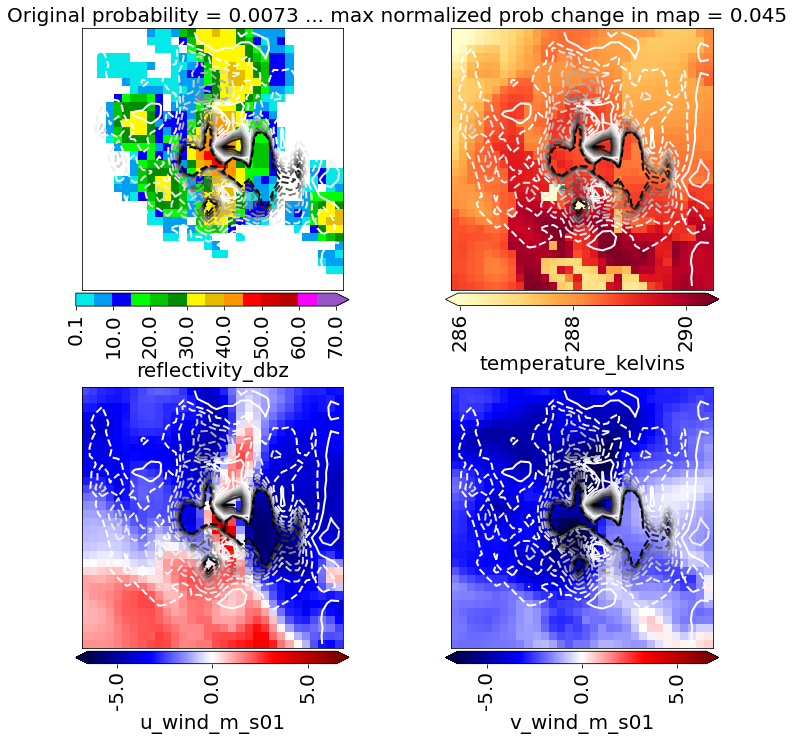

In [ ]:
predictor_matrix_denorm = testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

num_examples = predictor_matrix_denorm.shape[0]
random_index = random.randint(0, num_examples - 1)
# random_index = 14138
predictor_matrix_denorm = predictor_matrix_denorm[random_index, ...]

predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

occlusion_prob_matrix, original_probs = occlusion.get_occlusion_maps(
    model_object=cnn_model_object,
    predictor_matrix=numpy.expand_dims(predictor_matrix_norm, axis=0),
    half_window_size_px=1, fill_value=0.
)
normalized_occlusion_matrix = occlusion.normalize_occlusion_maps(
    occlusion_prob_matrix=occlusion_prob_matrix, original_probs=original_probs
)
# normalized_occlusion_matrix = saliency.smooth_saliency_maps(
#     occlusion_prob_matrix=normalized_occlusion_matrix,
#     smoothing_radius_grid_cells=1
# )

normalized_occlusion_matrix = normalized_occlusion_matrix[0, ...]
original_prob = original_probs[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(image_utils.U_WIND_NAME),
    predictor_names.index(image_utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_contour_value = numpy.percentile(
    normalized_occlusion_matrix[normalized_occlusion_matrix >= 0], 99
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        occlusion.plot_normalized_occlusion_map(
            normalized_occlusion_matrix_2d=normalized_occlusion_matrix,
            axes_object=axes_object_matrix[i, j],
            colour_map_object=pyplot.get_cmap('Greys'),
            max_contour_value=max_contour_value,
            contour_interval=max_contour_value / 8
        )

title_string = (
    'Original probability = {0:.4f} ... max normalized prob change in map '
    '= {1:.2g}'
).format(original_prob, max_contour_value)

figure_object.suptitle(title_string)

## Occlusion for strong example

The next cell computes and plots the occlusion map for the strongest example in the testing data (that with the greatest max future vorticity).

Occluding windows centered on row 1...
Occluding windows centered on row 2...
Occluding windows centered on row 3...
Occluding windows centered on row 4...
Occluding windows centered on row 5...
Occluding windows centered on row 6...
Occluding windows centered on row 7...
Occluding windows centered on row 8...
Occluding windows centered on row 9...
Occluding windows centered on row 10...
Occluding windows centered on row 11...
Occluding windows centered on row 12...
Occluding windows centered on row 13...
Occluding windows centered on row 14...
Occluding windows centered on row 15...
Occluding windows centered on row 16...
Occluding windows centered on row 17...
Occluding windows centered on row 18...
Occluding windows centered on row 19...
Occluding windows centered on row 20...
Occluding windows centered on row 21...
Occluding windows centered on row 22...
Occluding windows centered on row 23...
Occluding windows centered on row 24...
Occluding windows centered on row 25...
Occluding

Text(0.5, 0.98, 'Original probability = 1.0000 ... max normalized prob change in map = 3.6e-07')

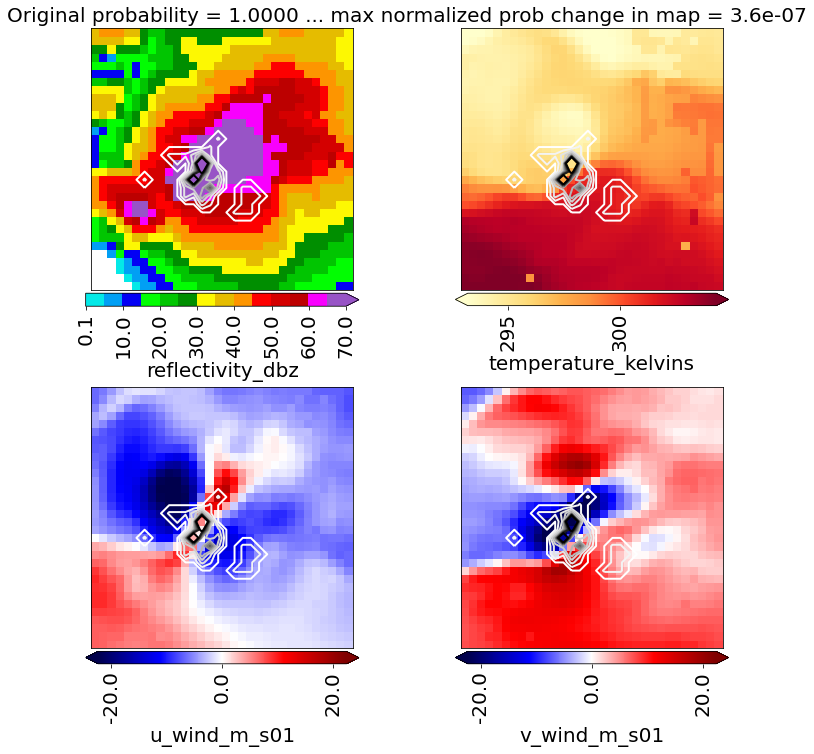

In [ ]:
target_matrix_s01 = testing_image_dict[image_utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix_denorm = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY][example_index, ...]
)
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

occlusion_prob_matrix, original_probs = occlusion.get_occlusion_maps(
    model_object=cnn_model_object,
    predictor_matrix=numpy.expand_dims(predictor_matrix_norm, axis=0),
    half_window_size_px=1, fill_value=0.
)
normalized_occlusion_matrix = occlusion.normalize_occlusion_maps(
    occlusion_prob_matrix=occlusion_prob_matrix, original_probs=original_probs
)
# normalized_occlusion_matrix = saliency.smooth_saliency_maps(
#     occlusion_prob_matrix=normalized_occlusion_matrix,
#     smoothing_radius_grid_cells=1
# )

normalized_occlusion_matrix = normalized_occlusion_matrix[0, ...]
original_prob = original_probs[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(image_utils.U_WIND_NAME),
    predictor_names.index(image_utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_contour_value = numpy.percentile(
    normalized_occlusion_matrix[normalized_occlusion_matrix >= 0], 99
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        occlusion.plot_normalized_occlusion_map(
            normalized_occlusion_matrix_2d=normalized_occlusion_matrix,
            axes_object=axes_object_matrix[i, j],
            colour_map_object=pyplot.get_cmap('Greys'),
            max_contour_value=max_contour_value,
            contour_interval=max_contour_value / 8
        )

title_string = (
    'Original probability = {0:.4f} ... max normalized prob change in map '
    '= {1:.2g}'
).format(original_prob, max_contour_value)

figure_object.suptitle(title_string)

## Occlusion for extreme cases

The next two cells compute, then plot, the composite (PMM) occlusion map for each set of extreme cases.

In [ ]:
bh_occlusion_prob_matrix, bh_original_probs = occlusion.get_occlusion_maps(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[BEST_HIT_MATRIX_KEY],
    half_window_size_px=1, fill_value=0.
)
bh_norm_occlusion_matrix = occlusion.normalize_occlusion_maps(
    occlusion_prob_matrix=bh_occlusion_prob_matrix,
    original_probs=bh_original_probs
)
bh_mean_original_prob = numpy.mean(bh_original_probs)
bh_norm_occlusion_matrix = utils.run_pmm_many_variables(
    field_matrix=numpy.expand_dims(bh_norm_occlusion_matrix, axis=-1)
)[..., 0]

wfa_occlusion_prob_matrix, wfa_original_probs = occlusion.get_occlusion_maps(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[WORST_FALSE_ALARM_MATRIX_KEY],
    half_window_size_px=1, fill_value=0.
)
wfa_norm_occlusion_matrix = occlusion.normalize_occlusion_maps(
    occlusion_prob_matrix=wfa_occlusion_prob_matrix,
    original_probs=wfa_original_probs
)
wfa_mean_original_prob = numpy.mean(wfa_original_probs)
wfa_norm_occlusion_matrix = utils.run_pmm_many_variables(
    field_matrix=numpy.expand_dims(wfa_norm_occlusion_matrix, axis=-1)
)[..., 0]

wm_occlusion_prob_matrix, wm_original_probs = occlusion.get_occlusion_maps(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[WORST_MISS_MATRIX_KEY],
    half_window_size_px=1, fill_value=0.
)
wm_norm_occlusion_matrix = occlusion.normalize_occlusion_maps(
    occlusion_prob_matrix=wm_occlusion_prob_matrix,
    original_probs=wm_original_probs
)
wm_mean_original_prob = numpy.mean(wm_original_probs)
wm_norm_occlusion_matrix = utils.run_pmm_many_variables(
    field_matrix=numpy.expand_dims(wm_norm_occlusion_matrix, axis=-1)
)[..., 0]

bcn_occlusion_prob_matrix, bcn_original_probs = occlusion.get_occlusion_maps(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[BEST_CORRECT_NULLS_MATRIX_KEY],
    half_window_size_px=1, fill_value=0.
)
bcn_norm_occlusion_matrix = occlusion.normalize_occlusion_maps(
    occlusion_prob_matrix=bcn_occlusion_prob_matrix,
    original_probs=bcn_original_probs
)
bcn_mean_original_prob = numpy.mean(bcn_original_probs)
bcn_norm_occlusion_matrix = utils.run_pmm_many_variables(
    field_matrix=numpy.expand_dims(bcn_norm_occlusion_matrix, axis=-1)
)[..., 0]

Occluding windows centered on row 1...
Occluding windows centered on row 2...
Occluding windows centered on row 3...
Occluding windows centered on row 4...
Occluding windows centered on row 5...
Occluding windows centered on row 6...
Occluding windows centered on row 7...
Occluding windows centered on row 8...
Occluding windows centered on row 9...
Occluding windows centered on row 10...
Occluding windows centered on row 11...
Occluding windows centered on row 12...
Occluding windows centered on row 13...
Occluding windows centered on row 14...
Occluding windows centered on row 15...
Occluding windows centered on row 16...
Occluding windows centered on row 17...
Occluding windows centered on row 18...
Occluding windows centered on row 19...
Occluding windows centered on row 20...
Occluding windows centered on row 21...
Occluding windows centered on row 22...
Occluding windows centered on row 23...
Occluding windows centered on row 24...
Occluding windows centered on row 25...
Occluding

Text(0.5, 0.98, 'Best correct nulls ... mean original prob = 0.0043 ... max normalized change = 0.0013')

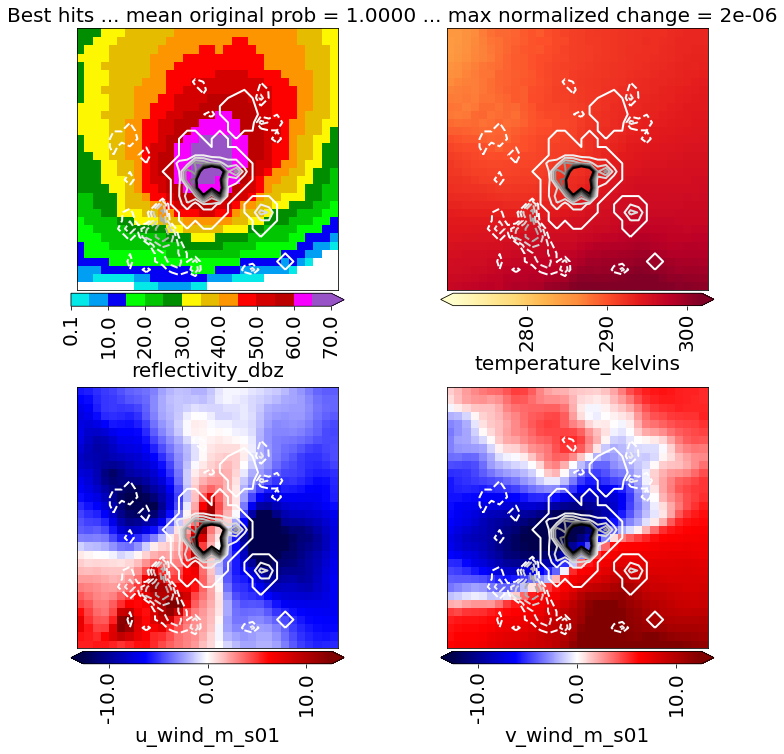

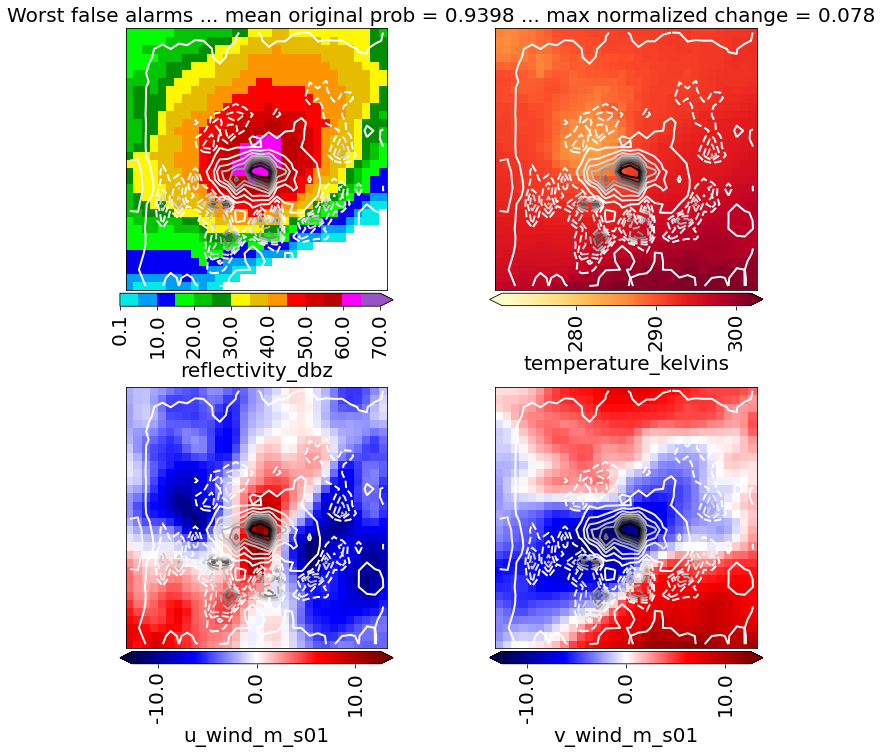

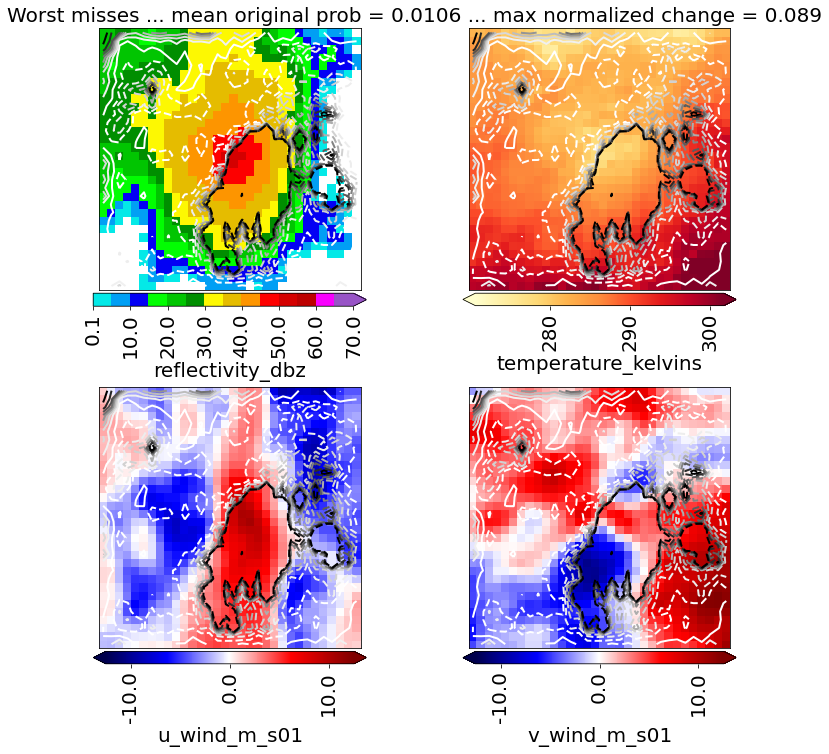

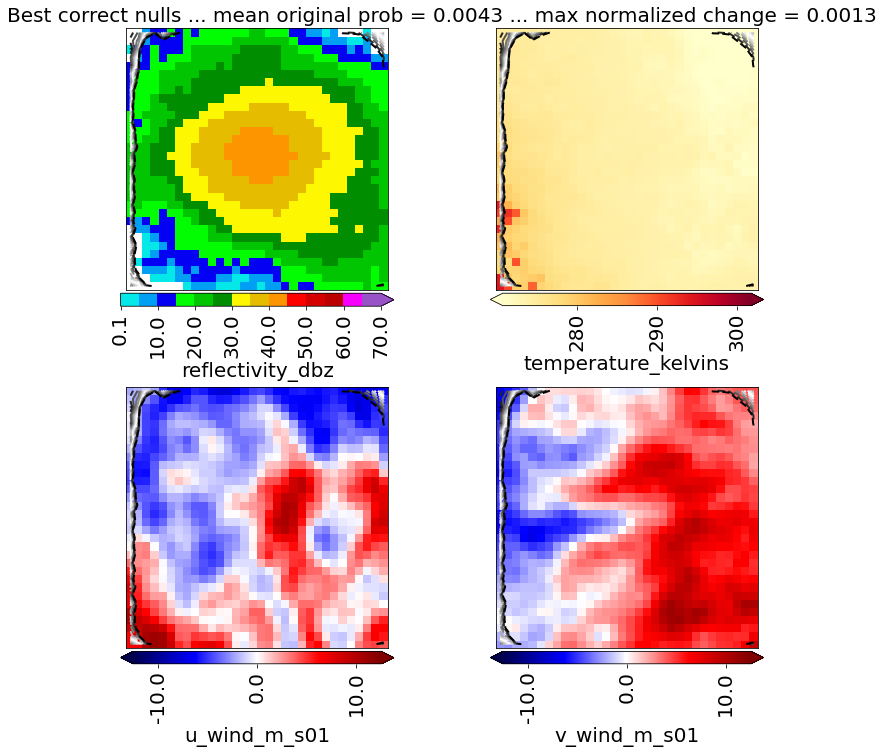

In [ ]:
predictor_names = extreme_example_dict_denorm_pmm[PREDICTOR_NAMES_KEY]

concat_predictor_matrix = numpy.stack((
    extreme_example_dict_denorm_pmm[BEST_HIT_MATRIX_KEY],
    extreme_example_dict_denorm_pmm[WORST_FALSE_ALARM_MATRIX_KEY],
    extreme_example_dict_denorm_pmm[WORST_MISS_MATRIX_KEY],
    extreme_example_dict_denorm_pmm[BEST_CORRECT_NULLS_MATRIX_KEY]
), axis=0)

temperature_matrix_kelvins = concat_predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(image_utils.U_WIND_NAME),
    predictor_names.index(image_utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(concat_predictor_matrix[..., wind_indices]), 99
)

this_max_contour_value = numpy.percentile(
    bh_norm_occlusion_matrix[bh_norm_occlusion_matrix >= 0], 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=extreme_example_dict_denorm_pmm[BEST_HIT_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        occlusion.plot_normalized_occlusion_map(
            normalized_occlusion_matrix_2d=bh_norm_occlusion_matrix,
            axes_object=axes_object_matrix[i, j],
            colour_map_object=pyplot.get_cmap('Greys'),
            max_contour_value=this_max_contour_value,
            contour_interval=this_max_contour_value / 8
        )

title_string = (
    'Best hits ... mean original prob = {0:.4f} ... max normalized change '
    '= {1:.2g}'
).format(bh_mean_original_prob, this_max_contour_value)

figure_object.suptitle(title_string)

this_max_contour_value = numpy.percentile(
    wfa_norm_occlusion_matrix[wfa_norm_occlusion_matrix >= 0], 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=
        extreme_example_dict_denorm_pmm[WORST_FALSE_ALARM_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        occlusion.plot_normalized_occlusion_map(
            normalized_occlusion_matrix_2d=wfa_norm_occlusion_matrix,
            axes_object=axes_object_matrix[i, j],
            colour_map_object=pyplot.get_cmap('Greys'),
            max_contour_value=this_max_contour_value,
            contour_interval=this_max_contour_value / 8
        )

title_string = (
    'Worst false alarms ... mean original prob = {0:.4f} ... max normalized '
    'change = {1:.2g}'
).format(wfa_mean_original_prob, this_max_contour_value)

figure_object.suptitle(title_string)

this_max_contour_value = numpy.percentile(
    wm_norm_occlusion_matrix[wm_norm_occlusion_matrix >= 0], 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=
        extreme_example_dict_denorm_pmm[WORST_MISS_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        occlusion.plot_normalized_occlusion_map(
            normalized_occlusion_matrix_2d=wm_norm_occlusion_matrix,
            axes_object=axes_object_matrix[i, j],
            colour_map_object=pyplot.get_cmap('Greys'),
            max_contour_value=this_max_contour_value,
            contour_interval=this_max_contour_value / 8
        )

title_string = (
    'Worst misses ... mean original prob = {0:.4f} ... max normalized '
    'change = {1:.2g}'
).format(wm_mean_original_prob, this_max_contour_value)

figure_object.suptitle(title_string)

this_max_contour_value = numpy.percentile(
    bcn_norm_occlusion_matrix[bcn_norm_occlusion_matrix >= 0], 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=
        extreme_example_dict_denorm_pmm[BEST_CORRECT_NULLS_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        occlusion.plot_normalized_occlusion_map(
            normalized_occlusion_matrix_2d=bcn_norm_occlusion_matrix,
            axes_object=axes_object_matrix[i, j],
            colour_map_object=pyplot.get_cmap('Greys'),
            max_contour_value=this_max_contour_value,
            contour_interval=this_max_contour_value / 8
        )

title_string = (
    'Best correct nulls ... mean original prob = {0:.4f} ... max normalized '
    'change = {1:.2g}'
).format(bcn_mean_original_prob, this_max_contour_value)

figure_object.suptitle(title_string)

# Backwards optimization

## Theory

 - Backwards optimization (Erhan et al. 2009) goes by many names:
   - Feature optimization
   - Activation maximization
   - Optimal input
<br><br>
 - **Backwards optimization creates a synthetic image (data example) that minimizes or maximizes the activation of a given neuron.**
 - As for saliency, we will focus on the activation of the output neuron (probability of strong future rotation).
 - **The procedure is basically training in reverse:**
   - During training, gradient descent is used to minimize the loss function by adjusting model weights.
   - During backwards optimization, gradient descent is used to minimize/maximize neuron activation by adjusting model inputs (predictors).
   - If the goal is to maximize strong-rotation probability, we create an optimal rotating storm.
   - If the goal is to minimize strong-rotation probability, we create an optimal non-rotating storm.
<br><br>
 - Like training, backwards optimization is an iterative procedure.
 - **At each iteration the synthetic image is updated via the following rule:**<br><br>
<center>$\mathbf{X} \leftarrow \mathbf{X} - \alpha\frac{\partial J}{\partial \mathbf{X}}$</center>
<br><br>
 - $\mathbf{X}$ is the input tensor (multi-dimensional matrix with predictors)
 - $\alpha$ is the learning rate (user-defined)
 - $J$ is the loss function
<br><br>
 - **In the simplest framework, $J = (p - p^*)^2$**, where $p$ is the current probability and $p^*$ is the desired probability (0 or 1).
 - **Thus, the above equation can be written as:**<br><br>
<center>$\mathbf{X} \leftarrow \mathbf{X} - 2\alpha(p - p^*)\frac{\partial p}{\partial \mathbf{X}}$</center>
<br><br>
 - $\frac{\partial p}{\partial \mathbf{X}}$ is the saliency map, so backwards optimization = serially adding a small fraction of the saliency map to the image.
 - **After enough iterations, backwards optimization can generate a completely different image.**
 - Although saliency is a linear approximation, a new saliency map is created at each iteration of backwards optimization, linearized around the new synthetic storm.
 - **Thus, backwards optimization overcomes the linear limitation of saliency maps.**
<br><br>
 - The default loss function for backwards optimization is $(p - p^*)^2$.
 - **However, we use L$_{2}$ regularization to make the CNN produce more realistic storms:**
<br><br>
<center>$J = (p - p^*)^2 + \lambda_2 \lVert \mathbf{X} - \mathbf{X_0} \rVert^2$</center>
<br><br>
 - $\lambda_2$ = strength of L$_{2}$ penalty
 - $\mathbf{X_0}$ = predictor matrix (maps of reflectivity, temperature, $u$, and $v$) for original storm
 - $\mathbf{X}$ = predictor matrix for synthetic storm
<br><br>
 - **Lecture 5 will have more on physical constraints in XAI.**
<br><br>
 - (Dis)advantages of backwards optimization, **as opposed to saliency maps**, are listed below.
 - **Advantage: global, not local, approximation.**
   - Integrating saliency maps many times overcomes linear limitation
 - **Disadvantages:**
   - Sensitive to starting point (initial seed)
     - Different starting points can yield very different results (here, prototypical storms)
   - Results can be very unrealistic
     - Extrapolating outside realm of inputs seen during training

## Example 1

The next cell runs and plots backwards optimization for the most extreme testing example, with the objective of decreasing $p$.
We use the following hyperparameters (a fancy word for fudge factors that must be determined *a priori* by the user):
 - 1000 iterations
 - Learning rate of 10$^{-4}$
 - No L$_{2}$ penalty (completely unconstrained)

In [ ]:
target_matrix_s01 = testing_image_dict[image_utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

orig_predictor_matrix_denorm = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY][example_index, ...]
    + 0.
)
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

orig_predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(orig_predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

new_predictor_matrix_norm = backwards_opt.optimize_example_for_class(
    model_object=cnn_model_object, input_matrix=orig_predictor_matrix_norm,
    target_class=0, num_iterations=1000, learning_rate=0.0001,
    l2_weight=0.
)[0][0, ...]

new_predictor_matrix_denorm = normalization.denormalize_data(
    predictor_matrix=new_predictor_matrix_norm,
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

temperature_index = predictor_names.index(utils.TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate((
    orig_predictor_matrix_denorm[..., temperature_index],
    new_predictor_matrix_denorm[..., temperature_index]
), axis=0)

min_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, axes_object_matrix = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=orig_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Real example\n(before optimization)')

figure_object, axes_object_matrix = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=new_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Synthetic example\n(after optimization)')

FailedPreconditionError: ignored

## Example 2

The previous example only decreased strong-rotation probability from 100% to 99.5%.  Let's turn the learning rate up to 10$^{-3}$.

In [ ]:
target_matrix_s01 = testing_image_dict[image_utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

orig_predictor_matrix_denorm = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY][example_index, ...]
    + 0.
)
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

orig_predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=orig_predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
orig_predictor_matrix_norm = numpy.expand_dims(
    orig_predictor_matrix_norm, axis=0
)

new_predictor_matrix_norm = backwards_opt.optimize_example_for_class(
    model_object=cnn_model_object, input_matrix=orig_predictor_matrix_norm,
    target_class=0, num_iterations=1000, learning_rate=0.001,
    l2_weight=0.
)[0][0, ...]

new_predictor_matrix_denorm = normalization.denormalize_images(
    predictor_matrix=new_predictor_matrix_norm,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_index = predictor_names.index(utils.TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate((
    orig_predictor_matrix_denorm[..., temperature_index],
    new_predictor_matrix_denorm[..., temperature_index]
), axis=0)

min_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, axes_object_matrix = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=orig_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Real example\n(before optimization)')

figure_object, axes_object_matrix = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=new_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Synthetic example\n(after optimization)')

## Example 3

The previous example completely obliterated the storm (and left an unrealistic-looking reflectivity hole in the rotation center).  Let's turn the learning rate down to 2 $\times$ 10$^{-4}$, increase the number of iterations to 1200, and use L$_2$ regularization with a weight of 2 $\times$ 10$^{-5}$.

In [ ]:
target_matrix_s01 = testing_image_dict[image_utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

orig_predictor_matrix_denorm = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY][example_index, ...]
    + 0.
)
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

orig_predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=orig_predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
orig_predictor_matrix_norm = numpy.expand_dims(
    orig_predictor_matrix_norm, axis=0
)

new_predictor_matrix_norm = backwards_opt.optimize_example_for_class(
    model_object=cnn_model_object, input_matrix=orig_predictor_matrix_norm,
    target_class=0, num_iterations=1200, learning_rate=2e-4,
    l2_weight=2e-5
)[0][0, ...]

new_predictor_matrix_denorm = normalization.denormalize_images(
    predictor_matrix=new_predictor_matrix_norm,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_index = predictor_names.index(utils.TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate((
    orig_predictor_matrix_denorm[..., temperature_index],
    new_predictor_matrix_denorm[..., temperature_index]
), axis=0)

min_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, axes_object_matrix = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=orig_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Real example\n(before optimization)')

figure_object, axes_object_matrix = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=new_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Synthetic example\n(after optimization)')

## Example 4

The next cell optimizes the first testing example to increase $p$:

 - 1000 iterations
 - Learning rate of 10$^{-3}$
 - No L$_{2}$ penalty (completely unconstrained)

In [ ]:
orig_predictor_matrix_denorm = (
    testing_image_dict[utils.PREDICTOR_MATRIX_KEY][0, ...] + 0.
)
predictor_names = testing_image_dict[utils.PREDICTOR_NAMES_KEY]

orig_predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=orig_predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
orig_predictor_matrix_norm = numpy.expand_dims(
    orig_predictor_matrix_norm, axis=0
)

new_predictor_matrix_norm = backwards_opt.optimize_example_for_class(
    model_object=cnn_model_object, input_matrix=orig_predictor_matrix_norm,
    target_class=1, num_iterations=1000, learning_rate=0.001,
    l2_weight=0.
)[0][0, ...]

new_predictor_matrix_denorm = normalization.denormalize_images(
    predictor_matrix=new_predictor_matrix_norm,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_index = predictor_names.index(utils.TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate((
    orig_predictor_matrix_denorm[..., temperature_index],
    new_predictor_matrix_denorm[..., temperature_index]
), axis=0)

min_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, axes_object_matrix = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=orig_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Real example\n(before optimization)')

figure_object, axes_object_matrix = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=new_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Synthetic example\n(after optimization)')